The code comes from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost, https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt and https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook

In [222]:
#imports for the notebook
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [223]:
#dataframe with daily data
df = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/daily_data.csv")

In [224]:
# Set datetime as index
df.rename(columns={"Unnamed: 0": "datetime"}, inplace = True)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
#drop first row
df.drop("2012-01-01", inplace=True)

# Split in train/test datasets

In [225]:
#Split the data between train and test data on the 1st January 2019 
split_date = '2019-01-01'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

# Create XGBoost model

In [226]:
#Features used for the prediction
Features = ['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'inflow_linth (m3/s)', 'outflow_limmat (m3/s)', 'precipitation (mm)',
       'change_rate', 'Evapotranspiration (mm)']
#Target variable
Target = 'water_level'

In [227]:
#Train dataset is split in features and target datasets
X_train = df_train[Features]
y_train = df_train[Target]

#Test dataset is split in features and target datasets
X_test = df_test[Features]
y_test = df_test[Target]

In [228]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01, max_depth=3)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:401.37935	validation_1-rmse:401.40388
[100]	validation_0-rmse:146.97594	validation_1-rmse:147.00048
[200]	validation_0-rmse:53.81917	validation_1-rmse:53.84371
[300]	validation_0-rmse:19.70778	validation_1-rmse:19.73234
[400]	validation_0-rmse:7.21735	validation_1-rmse:7.24196
[500]	validation_0-rmse:2.64503	validation_1-rmse:2.66576
[600]	validation_0-rmse:0.97120	validation_1-rmse:0.98743
[700]	validation_0-rmse:0.35917	validation_1-rmse:0.37601
[800]	validation_0-rmse:0.13820	validation_1-rmse:0.15435
[900]	validation_0-rmse:0.06366	validation_1-rmse:0.07640
[999]	validation_0-rmse:0.04376	validation_1-rmse:0.05175


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Feature Importance

In [229]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns = ["importance"])
fi

,importance
suction_tension (20cm),0.022916
suction_tension (40cm),0.029054
suction_tension (70cm),0.040045
water_temperature,0.242452
barometric_pressure_qfe,0.005954
dew_point,0.053268
inflow_linth (m3/s),0.341478
outflow_limmat (m3/s),0.155548
precipitation (mm),0.011093
change_rate,0.027273


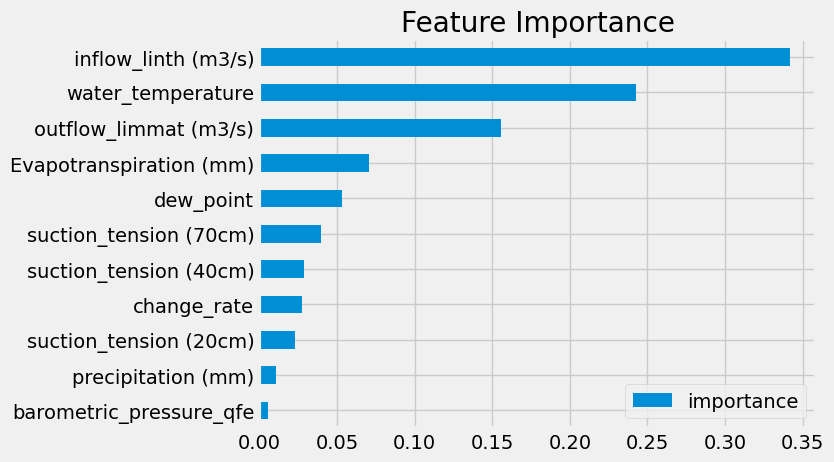

In [230]:
#Plot what has been the most used by the model
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on test data

In [231]:
X_test['prediction'] = reg.predict(X_test)

In [232]:
df = df.merge(X_test[['prediction']], how='left', left_index=True, right_index=True)
df

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),change_rate,Evapotranspiration (mm),prediction
datetime,,,,,,,,,,,,,
2012-01-02,2.085417,1.595833,1.770833,6.048611,969.075000,5.038889,405.913472,35.996333,121.419250,8.0,0.000004,0.04,NaN
2012-01-03,2.179167,1.700000,1.641667,5.959722,976.445833,0.961111,405.923819,38.921458,121.583167,1.1,0.000025,0.25,NaN
2012-01-04,1.745833,1.375000,1.606250,5.915972,974.427778,1.297917,405.926250,39.451292,121.705458,9.9,0.000006,0.11,NaN
2012-01-05,1.435417,1.189583,1.543750,5.731250,961.188194,1.251389,405.925625,41.358000,138.889167,21.0,-0.000002,0.06,NaN
2012-01-06,1.787500,1.358333,1.504167,5.537500,971.360417,0.265278,405.948958,46.956417,141.751208,1.9,0.000057,0.05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-23,4.255208,3.026875,3.247500,10.315278,949.419444,3.397917,405.948889,45.610375,73.740125,0.0,-0.000027,0.16,405.928619
2019-11-24,4.528125,3.240625,3.990000,10.234028,958.042361,4.770139,405.942014,43.226625,72.923125,0.0,-0.000017,0.11,405.914551
2019-11-25,4.723958,3.411458,4.289792,10.204861,962.402917,5.890139,405.941597,41.914958,64.105333,0.0,-0.000001,0.06,405.915131


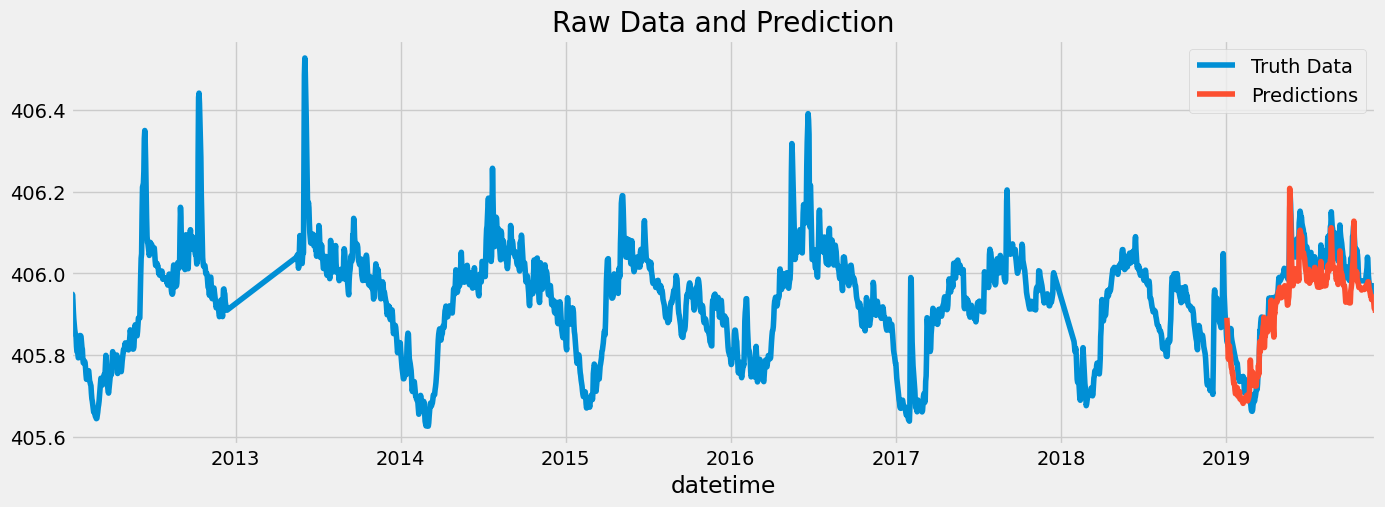

In [233]:
ax = df[['water_level']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

# Score

In [234]:
score = np.sqrt(mean_squared_error(df_test['water_level'], X_test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.05


# Othe approach to time series cross validation

In [235]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=300, gap=1)
df = df.sort_index()

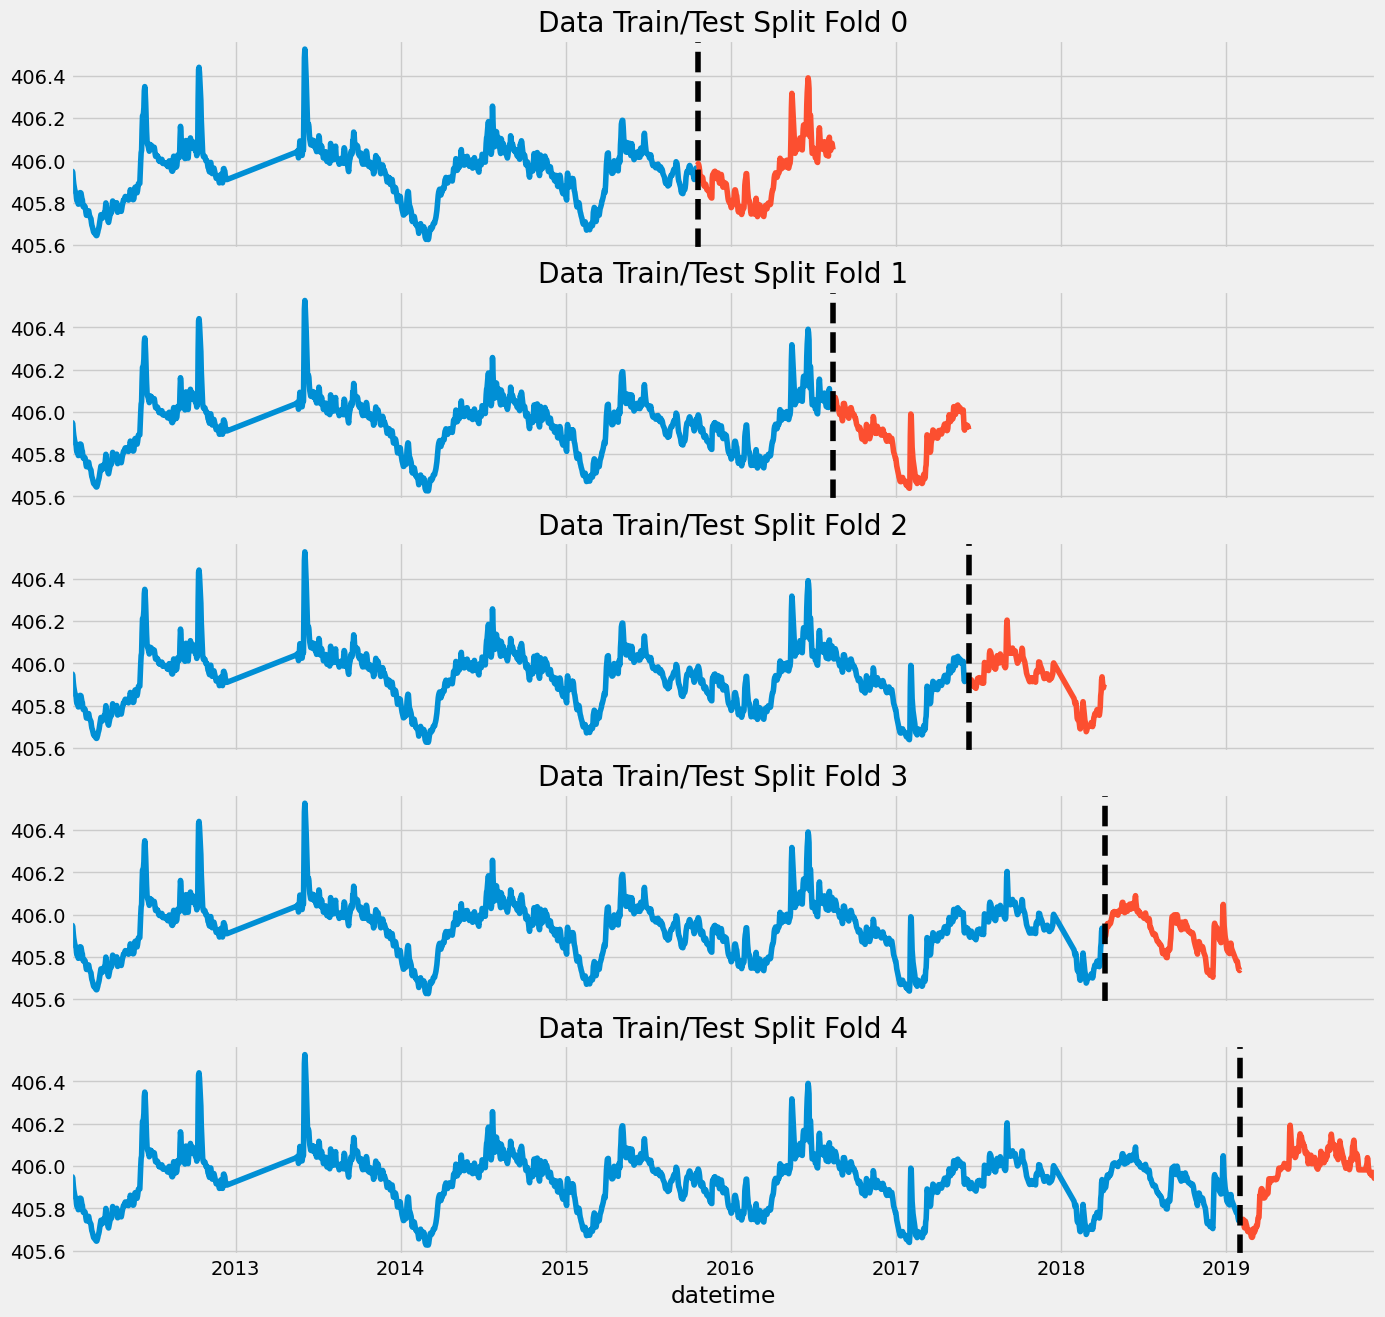

In [236]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['water_level'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Adding lags as a feature 

In [237]:
#We can use past values of our target variable as a feature

def add_lags(df):
    target_map = df['water_level'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map) #we use value from the day before
    df['lag2'] = (df.index - pd.Timedelta('5 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('10 days')).map(target_map)
    return df

In [238]:
df = add_lags(df)

In [239]:
#Adding lags to list of features
Features.extend(('lag1','lag2','lag3'))

# Training and testing with cross validation

In [240]:
tss = TimeSeriesSplit(n_splits=5, test_size=300, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[Features]
    y_train = train[Target]

    X_test = test[Features]
    y_test = test[Target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[18:56:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:401.39369	validation_1-rmse:401.38559
[100]	validation_0-rmse:147.03011	validation_1-rmse:147.02202
[200]	validation_0-rmse:53.85714	validation_1-rmse:53.84907
[300]	validation_0-rmse:19.72816	validation_1-rmse:19.72013
[400]	validation_0-rmse:7.22744	validation_1-rmse:7.21954
[500]	validation_0-rmse:2.64966	validation_1-rmse:2.65219
[600]	validation_0-rmse:0.97287	validation_1-rmse:0.98066
[700]	validation_0-rmse:0.35799	validation_1-rmse:0.36110
[800]	validation_0-rmse:0.13246	validation_1-rmse:0.13386
[900]	validation_0-rmse:0.04963	validation_1-rmse:0.05131
[999]	validation_0-rmse:0.01968	validation_1-rmse:0.02290
[18:56:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboo

In [241]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0210
Fold scores:[0.02289843863614668, 0.02122544839342997, 0.01912604360871869, 0.018203978645898736, 0.02365438744010655]
